# Pandas grouping and debiasing

Here we show how to average over independent groups of samples and discuss the biases that zero padding can introduce.

This notebook uses a generator for long-range correlated noise which can be obtained via: `pip install colorednoise` or [at github](//github.com/felixpatzelt/colorednoise).

Averaging over groups of samples is a bit slower than using a combined time series, but it allows to calculate the average 
correlation while ensuring that each group has the same weight and that only correlations 
within each group are counted. A typical application is analysing intra-day trading.
The difference relative to the ungrouped estimate is not necessarily huge, but the
only way to verify this is to test it!

In [1]:
import numpy as np
import pandas as pd
# set the plotting backend
import matplotlib
matplotlib.use('nbagg') # change according to your needs: agg, tkagg, ...
import matplotlib.pyplot as plt
plt.ion()

In [2]:
import colorednoise as cn
import scorr

## generate correlated noise

In [3]:
group_length = 907 # choose a prime number to challenge FFT performance
groups       = 1000
# set the exponent of the power spectral density
beta  = .5
# generate time series
x = cn.powerlaw_psd_gaussian(beta, group_length * groups)
# label each sample with group number
d = np.repeat(np.arange(groups), group_length)
# create a dataframe
df = pd.DataFrame({'x': x,'d': d})

In [4]:
# beta in between 0 and 1 gives power-law autocorrelations with exponent:
gamma = 1. - beta
r_analytic = np.concatenate([[1],  np.arange(1,group_length)**-gamma])

## average over groups in different ways
The lenght of the segments that are Fourier transformed determines the longest valid lag and the performance of the FFT algorithm.

In [5]:
%%time
# use the exact group length for the fourier segments 
rdf_len = scorr.acorr_grouped_df(df, by='d', nfft='len')

CPU times: user 4.41 s, sys: 67.9 ms, total: 4.47 s
Wall time: 4.49 s


In [6]:
%%time
# pad to next larger power of two (default, usually fastest)
rdf_pad = scorr.acorr_grouped_df(df, by='d', nfft='pad')

CPU times: user 1.42 s, sys: 32.8 ms, total: 1.45 s
Wall time: 1.45 s


In [7]:
%%time
# crop to smaller power of two - slower due to intra-group averaging
rdf_crop = scorr.acorr_grouped_df(df, by='d', nfft='crop')

CPU times: user 2.25 s, sys: 30.4 ms, total: 2.28 s
Wall time: 2.28 s


In [8]:
%%time
# perfectly demix causal and anticausal parts
rdf_demix = scorr.acorr_grouped_df(df, by='d', nfft='demix')

CPU times: user 1.59 s, sys: 39.9 ms, total: 1.63 s
Wall time: 1.64 s


In [9]:
%%time
# like demix, but don't correct the bias from zero padding
rdf_biased = scorr.acorr_grouped_df(df, by='d', nfft='demix', debias=False)

CPU times: user 1.28 s, sys: 25.7 ms, total: 1.31 s
Wall time: 1.31 s


<IPython.core.display.Javascript object>


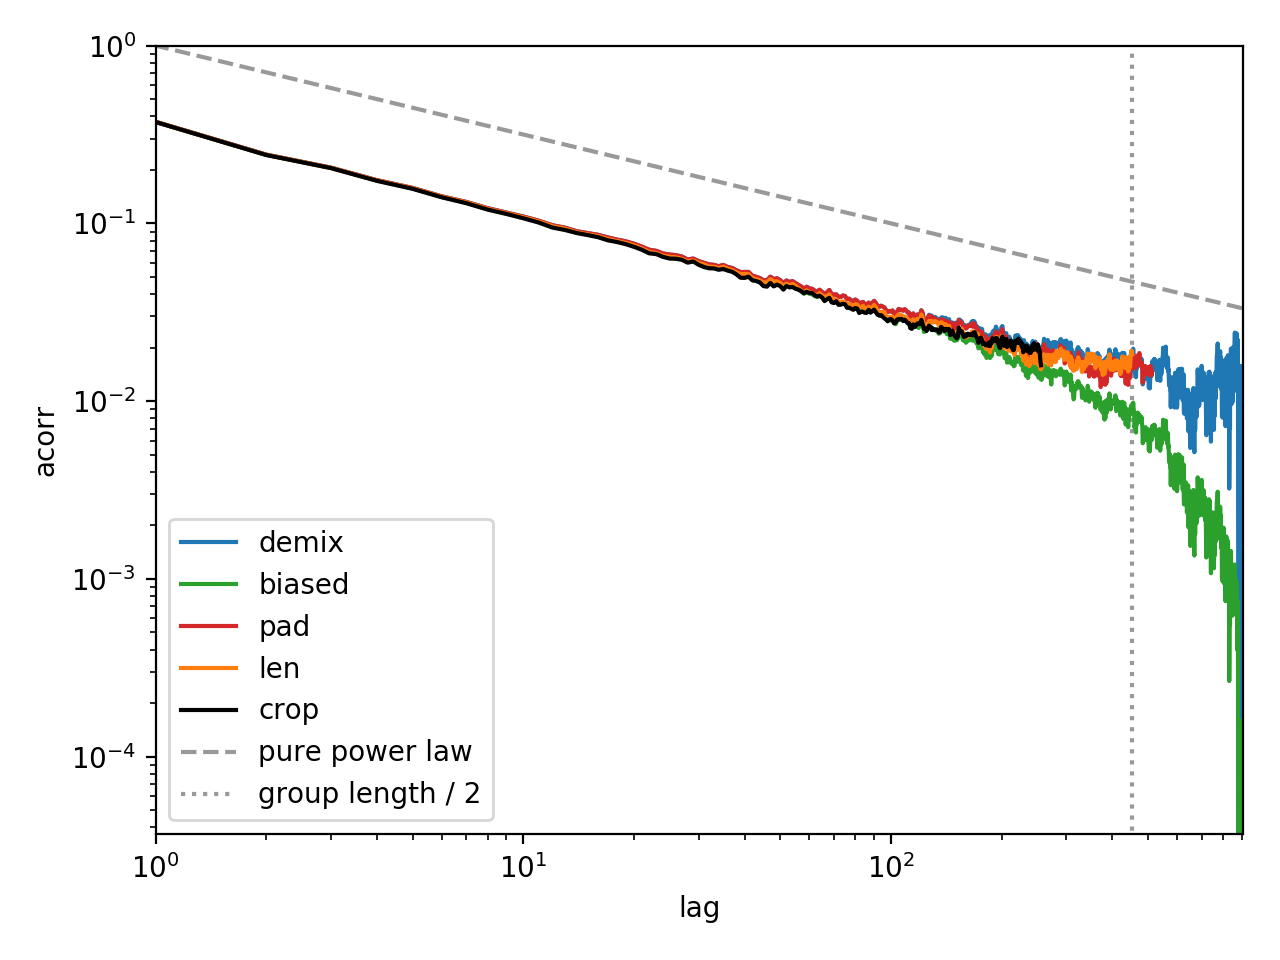

In [10]:
fig, ax = plt.subplots()
pkwa = {'ax':ax, 'logx': True, 'logy': True}

rdf_demix['acorr'].plot(color='C0', label='demix', **pkwa)
rdf_biased['acorr'].plot(color='C2', label='biased', **pkwa)
rdf_pad['acorr'].plot(color='C3', label='pad', **pkwa)
rdf_len['acorr'].plot(color='C1', label='len', **pkwa)
rdf_crop['acorr'].plot(color='k', label='crop', **pkwa)

ax.plot(r_analytic, '--', color='#999999', label='pure power law')
ax.vlines(
    [group_length/2], rdf_biased.min(), 1, 
    linestyle=':', color='#999999', label='group length / 2'
)

ax.legend()
ax.set_ylim([r_analytic[-1]/group_length, 1])
ax.set_ylabel('acorr')
fig.tight_layout()